# クラウドへ（そしてその先へ）
数値の問題を解決する方法については十分に検討しました。トレーニング部分をクラウドに移行します。この場合も同様です。（数値の問題にはこれ以上は不要ですが、他の問題については、ローカルでサブセットの問題をテストしてからクラウドに移動して全体を処理します）

いくつか設定しましょう。

最初にしなければならないことは、azureml.core パッケージがノートブック環境にインストールされているのを確認することです。Azure Notebooksを使用している場合は、簡単な2ステップのプロセスで確認できます。

## Azure Notebooks に依存関係を追加する
"Project Settings" をクリックします。

![Project Setings](https://raw.githubusercontent.com/sethjuarez/pytorchintro/master/images/project_settings.png)

次に、"Environments" タブを選択し、"Python 3.6" を選択します。最後に、`requirements.txt` を選択します。

![Settings](https://raw.githubusercontent.com/sethjuarez/pytorchintro/master/images/settings.png)

これらのステップで、実行できるようになるはずです。

注: もし上記の設定をしても問題が発生する場合は、Notebook でカーネルが Python 3.6 に設定されていることを確認してください。次の操作で設定できます:
Select Kernel - Change Kernel - Python 3.6

In [1]:
import json
import time
import azureml
from azureml.core.model import Model
from azureml.core import Workspace, Run, Experiment
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails
from torchvision import datasets, transforms

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


# Azure Machine Learning サービスを設定する
最初に必要な作業は、Azure Machine Learning ワークスペースを作成することです。その方法についての [ドキュメント](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started#create-a-workspace) があります。コマンドラインタイプに慣れている場合は、Azure CLI を使用してセットアップする方法の [例](https://github.com/sethjuarez/workspacestarter) があります。プロジェクトを設定したら、以下のコードのコメントを外して設定ファイルを書き出し、ワークスペースに適した設定を入力します。設定ファイルが書き出されたら、下記のようにプログラムでワークスペースをロードすることができます。

In [2]:
##use this code to set up config file
#subscription_id ='<SUB_ID>'
#resource_group ='<RESOURCE_GROUP>'
#workspace_name = '<WORKSPACE>'

#try:
#    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
#    ws.write_config()
#    print('Workspace configuration succeeded. You are all set!')
#except:
#    print('Workspace not found. TOO MANY ISSUES!!!')

##once you run the above code once, you can use the written config
ws = Workspace.from_config()

Found the config file in: C:\projects\pytorchintro\aml_config\config.json


# クラウドコンピュート
次に、実験用のコンピュートターゲットを定義する必要があります。これはまったく新しいワークスペースなので、クラスタの名前を変更してください（私は 'racer' と呼んでいます）。以下のコードは自分のクラスタへの参照を取得しようとしますが、存在しない場合は作成します。クラスタを作成する場合、少し時間がかかります。また、予想外の課金をされないように、実験が完了したらクラスターをオフにしてください（実際には、min_node を 0 に設定して、長時間アイドル状態になるとクラスタが自動的にオフになることを検討してください）。 

In [4]:
cluster = 'racer'
try:
    compute = ComputeTarget(workspace=ws, name=cluster)
    print('Found existing compute target "{}"'.format(cluster))
except ComputeTargetException:
    print('Creating new compute target "{}"...'.format(cluster))
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', min_nodes=1, max_nodes=6)
    compute = ComputeTarget.create(ws, cluster, compute_config)
    compute.wait_for_completion(show_output=True)

Found existing compute target "racer"


# 実験の時間
コンピューティングターゲットが設定されたら、前回の小さなノートブックをリモートコンピューティング環境で実行できる単一のスクリプトにパッケージ化します。[あなたのために](train.py) 作っておきました。実際、ファイルを見ると、前のノートブックから学んだものとまったく同じ概念がすべて表示されます（これはほとんどまったく同じですが、スクリプトへの受け渡しを容易にするために追加の事項を入れています）。

Azure ML サービスには実験という概念があります。実験ごとに複数回実行することができます。ここでは、実験の実行方法を定義する Estimator オブジェクトを使用しています。

### バックグラウンドで何をしてるか気にしないのであれば、ここを読んではいけません
バックグラウンドでは、Estimator は基本的に実験を格納する docker イメージの定義です。このすべてについての最もよい部分は、あなたがあなたの実験に使うもの（TensorFlowの狂ったカスタムバージョンであっても他の何かであっても）に関係なく、それが必ず実行可能であるということです - 結局それはコンテナです。とても使いやすいです。

### 通常の手順に戻る
Estimator を Azure ML サービスで実行することを送信すると、現在のディレクトリの内容がコピーされ、新しいコンテナにまとめられます（それらは [.amlignore] ファイルに記述されたもの以外、全部アップロードされます）

また、'argparse' を使用しているので、推論器定義の一部としてトレーニングスクリプトに外部パラメータを指定できます。

次の3行を実行して、何が起こるのか見てみましょう。

In [5]:
# Create and run experiment
mnist = Experiment(ws, 'pytorchmnist')

# script parameters
script_params={
    '--epochs': 5,
    '--batch': 100,
    '--lr': .001,
    '--model': 'cnn'
}

# Create Estimator
estimator = PyTorch(source_directory='.',
                       compute_target=compute, 
                       entry_script='train.py',
                       script_params=script_params,
                       use_gpu=True)

run = mnist.submit(estimator)

In [6]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
pytorchmnist,pytorchmnist_1545340099288,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [7]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

すべて完了すると、次のようになります:

![AzureML Run](https://raw.githubusercontent.com/sethjuarez/pytorchintro/master/images/run_widget.png)

実際に、損失関数は時間の経過とともに（平均して）減少し、モデルの精度が上がったことに注意してください。learning_rate パラメータを変更して試してみてください。詳しくは、[Azure Machine Learning service でモデルのハイパーパラメーターを調整する](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) を参照してください。

さて、どのようにしてこれらの素晴らしいチャートを表示させられたのか疑問に思うかもしれません。これは Azure ML サービスが、あなたがすでにやっていたことに対して実用的な価値を付加してくれるところです。[いくつか](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L156-L166) の [戦略的](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L121-L122) に [配置](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L142-L143) されたログステートメントを使用して、Azure ML サービスはこの出力を作成しました。実際、値が複数回ログに記録されると、テーブル内の項目ではなくチャートが自動的に作成されます。

# モデル
トレーニングがすべて完了して出力が完了したら、実際に特定の実験のすべての実行の出力を確認し、それを「公式な」ワークスペースモデルに昇格させることができます。重要なファイル（つまり私たちをお金持ちにしてくれるかもしれないモデル）が通常 Jeff という名前のコンピュータ上に置かれるのは素晴らしい機能です。また現在は、多くの人がモデルのバージョン管理さえしていません。以下のコードを実行してください。

In [8]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/80_driver_log.txt',
 'outputs/model.pth',
 'outputs/model.onnx',
 'driver_log',
 'azureml-logs/azureml.log',
 'azureml-logs/55_batchai_execution.txt']

In [9]:
model_file = 'outputs/model.pth'
run.download_file(name=model_file, output_file_path='model.pth')
model = Model.register(ws, model_name='PyTorchMNIST', model_path='model.pth', 
                       description='CNN PyTorch Model')

Registering model PyTorchMNIST


# イメージ
モデルが完成したので、それをプロダクションで使用する場合は、モデルの使用方法を定義する必要があります。これはスコアリングまたは推論とも呼ばれます。Azure ML サービスでは、基本的に2つのメソッドが必要です:
1. `init()`
2. `run(raw)` JSON 文字列を取り込んで予測を返す

最初にスコアスクリプトが実行される環境を記述し、それを環境ファイルにまとめる必要があります。

In [10]:
myenv = CondaDependencies()
myenv.add_pip_package('numpy')
myenv.add_pip_package('torch')
with open('pytorchmnist.yml','w') as f:
    print('Writing out {}'.format('pytorchmnist.yml'))
    f.write(myenv.serialize_to_string())
    print('Done!')

Writing out pytorchmnist.yml
Done!


次に、Azure ML サービスにスコアリングスクリプトの場所を通知する必要があります。[あらかじめ作っておきました](score.py)。ファイルを見ると、init() メソッドと run(raw) メソッドの両方が簡単に見つかるはずです。ファイルをローカルで実行して、正しい動作をしていることを確認することもできます。

これですべてが完成したので、イメージを作成しましょう。

### バックグラウンドで何をしてるか気にしないのであれば、ここを読んではいけません
基本的には、定義からdockerイメージを作成して、Workspace に表示される Azure Container Registry にプッシュします。

**注** しばらく時間がかかります

In [11]:
from azureml.core.image import ContainerImage, Image

# create image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                runtime="python", 
                                conda_file="pytorchmnist.yml")

image = Image.create(ws, 'pytorchmnist', [model], image_config)
image.wait_for_creation(show_output=True)

Creating image
Running.............................................
SucceededImage creation operation finished for image pytorchmnist:5, operation "Succeeded"


# デプロイ
イメージ作成をやめて、残りの展開プロセスを Azure Pipelines のようなものに移動したいかもしれません。このサービスを引き続きワークスペースにデプロイしたい場合は、以下を使用してください。

In [12]:
from azureml.core.webservice import Webservice, AciWebservice

service_name = 'pytorchmnist-svc'

# check for existing service
svcs = [svc for svc in Webservice.list(ws) if svc.name==service_name]
if len(svcs) == 1:
    print('Deleting prior {} deployment'.format(service_name))
    svcs[0].delete()

# create service
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                            memory_gb=1, 
                                            description='simple MNIST digit detection')
service = Webservice.deploy_from_image(workspace=ws, 
                                    image=image, 
                                    name=service_name, 
                                    deployment_config=aciconfig)
service.wait_for_deployment(show_output=True)
print(service.scoring_uri)

Deleting prior pytorchmnist-svc deployment
Creating service
Running.........................
SucceededACI service creation operation finished, operation "Succeeded"


イメージを ACI またはワークスペース Kubernetes クラスターにプッシュすることもできます。

時々うまくいかないことがあります・・・もし実行時にそうなったら、実際の [logs](deploy.log) を見てください。!

In [106]:
with open('deploy.log','w') as f:
    f.write(service.get_logs())

# サービスの実行
これで動作しています。適切に動作しているか見てみましょう。テストデータをロードして乱数を試すことができます。

In [14]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )
print(len(digits))

60000


インデックスとして基本的に最大60,000まで任意の数を選ぶことができます。サービスがどのように動作しているかを見るために何回か試してみてください。

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


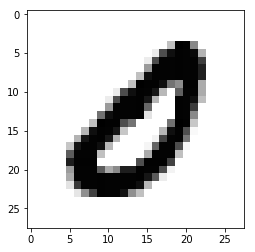

In [18]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

X, Y = digits[57435]
X = X * 255
plt.imshow(255 - X.reshape(28,28), cmap='gray')
print(Y)

In [16]:
# This is a string representation of the image we will POST to the endpoint
image_str = ','.join(map(str, X.int().tolist()))
print(image_str)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,246,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,252,252,193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,240,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,240,140,114,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,233,71,0,159,252,252,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,233,74,0,0,253,252,239,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,151,0,0,0,253,252,195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,141,240,252,252,252,253,27,0,0,0,253,252,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,178,140,0,0,0,0,141,255,2

In [17]:
import json
import requests
service_url = service.scoring_uri
print(service_url)
r = requests.post(service_url, json={'image': image_str })
r.json()

http://13.83.149.109:80/score


{'time': 0.104436,
 'prediction': 0,
 'scores': [0.995736837387085,
  2.3327098475078856e-08,
  0.003980344161391258,
  0.00016383796173613518,
  4.010713894331275e-08,
  5.167449853615835e-05,
  1.7358546756440774e-05,
  4.9987315833277535e-06,
  4.1949653677875176e-05,
  3.171517391820089e-06]}

## 最後に
この小さな旅が参考になっていればうれしい！ 私の目標は、機械学習の基本がそれほど悪いものではないことを示すことです。コメント、提案、または分からないところは一言教えてください。